In [1]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory
mv: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download --unzip -d farhanmonsur/breast-cancer-split-dataset

 99% 1.54G/1.55G [00:08<00:00, 238MB/s]
100% 1.55G/1.55G [00:08<00:00, 195MB/s]


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
#from keras.preprocessing.image import ImageDataGenerator

In [ ]:
TRAIN_PATH = "/content/All Data Split/Train/"
TEST_PATH = "/content/All Data Split/Test/"

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 128

train_ds = image_dataset_from_directory(TRAIN_PATH, image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))

test_ds = image_dataset_from_directory(TEST_PATH, image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, shuffle=False)
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

Found 212421 files belonging to 2 classes.
Found 65103 files belonging to 2 classes.


In [ ]:
print(f"Train set shape:\t{len(train_ds)} batches")
print(f"Test set shape: \t{len(test_ds)} batches")
print(f"Images per batch:\t{BATCH_SIZE} images")

Train set shape:	1660 batches
Test set shape: 	509 batches
Images per batch:	128 images


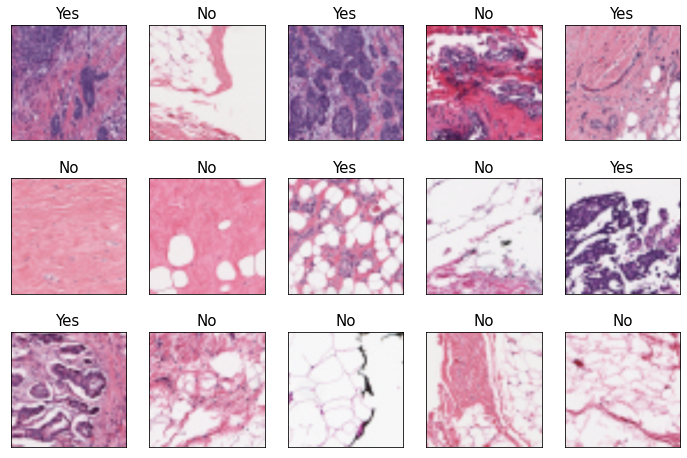

In [ ]:
for x in train_ds.take(1):

    plt.figure(figsize=(12,8))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(x[0][i])

        if x[1][i] == 0:
            plt.title("No", size = 15, color = "black")
        if x[1][i] == 1:
            plt.title("Yes", size = 15, color = "black")

        plt.xticks([])
        plt.yticks([])

In [ ]:
from keras.applications import VGG19

base_model = VGG19(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
X = Flatten()(base_model.output)
X = Dense(units = 1, activation = 'sigmoid')(X)

model = Model(base_model.input, X)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# FILTER = 2

# inputs = tf.keras.Input(shape=(50, 50, 3))

# b1c1 = Conv2D(FILTER, (3, 3), padding="same", activation="relu")(inputs)
# b1c2 = Conv2D(FILTER, (3, 3), padding="same", activation="relu")(b1c1)
# mp1 = MaxPooling2D((2, 2))(b1c2)

# b2c1 = Conv2D(FILTER * 2, (3, 3), padding="same", activation="relu")(mp1)
# b2c2 = Conv2D(FILTER * 2, (3, 3), padding="same", activation="relu")(b2c1)
# mp2 = MaxPooling2D((2, 2))(b2c2)

# b3c1 = Conv2D(FILTER * 4, (3, 3), padding="same", activation="relu")(mp2)
# b3c2 = Conv2D(FILTER * 4, (3, 3), padding="same", activation="relu")(b3c1)
# mp3 = MaxPooling2D((2, 2))(b3c2)

# b4c1 = Conv2D(FILTER * 8, (3, 3), padding="same", activation="relu")(mp3)
# b4c2 = Conv2D(FILTER * 8, (3, 3), padding="same", activation="relu")(b4c1)
# mp4 = MaxPooling2D((2, 2))(b4c2)

# b5c1 = Conv2D(FILTER * 16, (3, 3), padding="same", activation="relu")(mp4)
# b5c2 = Conv2D(FILTER * 16, (3, 3), padding="same", activation="relu")(b5c1)
# mp5 = MaxPooling2D((2, 2))(b5c2)

# flat = Flatten()(mp5)

# outputs = Dense(1, activation="sigmoid")(flat)

# model = Model(inputs=inputs, outputs=outputs, name="CONVMODEL")
# model.compile(optimizer='adam', loss="binary_crossentropy", metrics = ['accuracy'])

# model.summary()

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import os
Root = "/content/drive/MyDrive/colab_notebook/Breast_Cancer_Classification"
os.chdir(Root)

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01,
                   patience = 5, verbose = 1, mode = 'auto')

mc = ModelCheckpoint('./vgg19model.h5', monitor = 'val_accuracy',
                     save_best_only=True, verbose = 1, mode = 'auto')

cb = [es, mc]

history = model.fit(train_ds, validation_data = test_ds, epochs = 10,
                    # steps_per_epoch= 8,
                    # validation_steps= 16,
                    callbacks = cb,
                    verbose = 1)

Epoch 1/10
1660/1660 [==============================] - ETA: 0s - loss: 0.3932 - accuracy: 0.8291
Epoch 1: val_accuracy improved from -inf to 0.83233, saving model to ./vgg19model.h5
1660/1660 [==============================] - 1640s 976ms/step - loss: 0.3932 - accuracy: 0.8291 - val_loss: 0.3959 - val_accuracy: 0.8323
Epoch 2/10
1660/1660 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.8427
Epoch 2: val_accuracy did not improve from 0.83233
1660/1660 [==============================] - 1614s 971ms/step - loss: 0.3656 - accuracy: 0.8427 - val_loss: 0.4194 - val_accuracy: 0.8170
Epoch 3/10
1660/1660 [==============================] - ETA: 0s - loss: 0.3531 - accuracy: 0.8484
Epoch 3: val_accuracy did not improve from 0.83233
1660/1660 [==============================] - 1614s 972ms/step - loss: 0.3531 - accuracy: 0.8484 - val_loss: 0.3895 - val_accuracy: 0.8304
Epoch 4/10
1660/1660 [==============================] - ETA: 0s - loss: 0.3488 - accuracy: 0.8502
Epoch 4

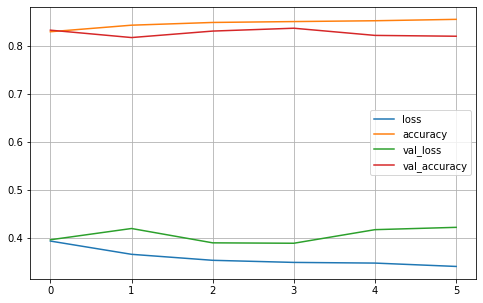

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 3)
plt.show()

1/1 [==============================] - 0s 139ms/step


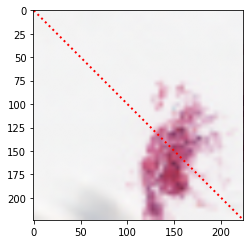

[[0.21056642]]
No


In [ ]:
from PIL import Image
model_path = "vgg19model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import numpy as np

# image = cv2.imread("/content/drive/MyDrive/colab_notebook/Breast_Cancer_Classification/10253/1/10253_idx5_x601_y401_class1.png")

img_path="/content/12820_idx5_x101_y801_class0.png"
# image = cv2.imread(img_path)

# image_fromarray = Image.fromarray(image, 'RGB')
# resize_image = image_fromarray.resize((224, 224))
# expand_input = np.expand_dims(resize_image,axis=0)
# input_data = np.array(expand_input)
# input_data = input_data/255

image = cv2.imread(img_path)[:,:,::-1]

resize_image = cv2.resize(image, (224, 224))
input_data = resize_image.reshape(-1, 224, 224, 3)
input_data = input_data / 255.

pred = loaded_model.predict(input_data)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
im = plt.imread(img_path)
fig, ax = plt.subplots()
im = ax.imshow(im, extent=[0, 300, 0, 300])
x = np.array(range(300))
ax.plot(x, x, ls='dotted', linewidth=2, color='red')
plt.imshow(input_data[0])
plt.show()

print(pred)

if pred >= 0.5:
  print("Yes")
else:
  print("No")

GradCam

In [ ]:
import tensorflow
def get_img_array(image_path, size):
    # `img` is a PIL image of size 299x299
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tensorflow.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def generate_gradcam_heatmap(image_array, model, lastconvlayername, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    layer_output = model.get_layer(lastconvlayername).output
    grad_model = tensorflow.keras.models.Model(
        [model.inputs], [layer_output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tensorflow.GradientTape() as tape:
        lastconv_layer_output, preds = grad_model(image_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, lastconv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tensorflow.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    lastconv_layer_output = lastconv_layer_output[0]
    heatmap = lastconv_layer_output @ pooled_grads[..., tensorflow.newaxis]
    heatmap = tensorflow.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tensorflow.maximum(heatmap, 0) / tensorflow.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Prepare image
from tensorflow.keras.preprocessing import image
img1=img_path
img_size=(224,224)

img = Image.open(img1).resize((224,224))

# Preprocessing the image
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img.astype('float32')/255

# Remove last layer's softmax
loaded_model.layers[-1].activation = None

# Print what the top predicted class is
preds = loaded_model.predict(img)

1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


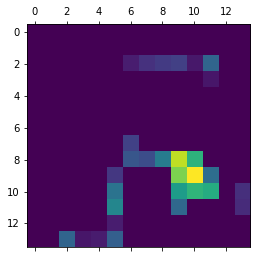

In [ ]:
# Generate class activation heatmap
last_conv_layer_name = "block5_conv4"
heatmap = generate_gradcam_heatmap(img, loaded_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def generate_heatmap(img_path,last_conv_layer_name):
  # Prepare image
  img_size=(224,224)

  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!

  # Preprocessing the image
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255

  # Remove last layer's softmax
  loaded_model.layers[-1].activation = None
  heatmap = generate_gradcam_heatmap(img, loaded_model, last_conv_layer_name)

  return heatmap

In [ ]:
heatmap =generate_heatmap(img1,"block5_conv4")

In [ ]:
from IPython.display import Image as imgdisp, display
import matplotlib.cm as cm
def save_and_display_gradcam(img_path, heatmap, cam_path="/content/drive/MyDrive/colab_notebook/cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)


    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(imgdisp(cam_path))

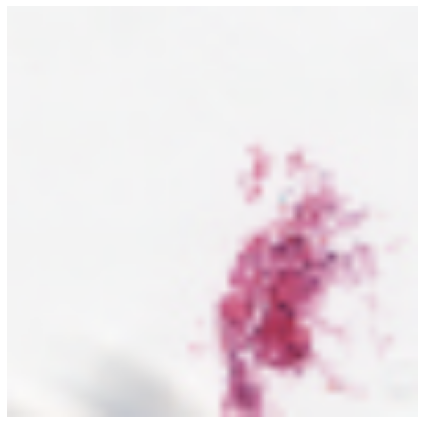

In [ ]:
# plt.rcParams["figure.figsize"] = [7.00, 3.50]
# plt.rcParams["figure.autolayout"] = True
plt.figure(figsize= (6, 6))
im = cv2.imread(img_path)[:,:,::-1]
im = cv2.resize(im,(224,224))
# fig, ax = plt.subplots()
# im = ax.imshow(im, extent=[0, 300, 0, 300])
# x = np.array(range(300))
# ax.plot(x, x, ls='dotted', linewidth=2, color='red')
plt.axis('off')
plt.imshow(im)
plt.show()

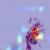

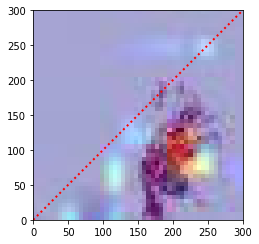

In [ ]:
heatmap =generate_heatmap(img1,"block5_conv4")
save_and_display_gradcam(img1, heatmap)
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
im = plt.imread("/content/drive/MyDrive/colab_notebook/cam.jpg")
fig, ax = plt.subplots()
im = ax.imshow(im, extent=[0, 300, 0, 300])
x = np.array(range(300))
ax.plot(x, x, ls='dotted', linewidth=2, color='red')
plt.show()

Performance Metrics

In [ ]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from math import sqrt
def mcc_function(tn, fp, fn, tp):
    x = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return ((tp * tn) - (fp * fn)) / sqrt(x)

In [ ]:
Y_actual = np.array([])

for t in test_ds.as_numpy_iterator():
    Y_actual = np.concatenate((Y_actual, t[1]))

In [ ]:
y_pred = loaded_model.predict(test_ds)
Y_pred = (y_pred > 0.5).astype(int).flatten()

509/509 [==============================] - 373s 734ms/step


Confusion Matrix
Sensitivity score: 0.6116666666666667
Specificity score: 0.9246407522680617
Matthews Correlation Coefficient: 0.5789613536602017


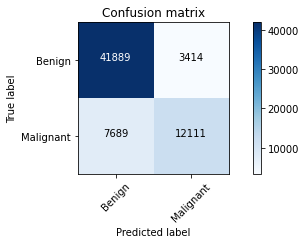

In [ ]:
print("Confusion Matrix")
cm = confusion_matrix(Y_actual, Y_pred)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)
mcc = mcc_function(tn, fp, fn, tp)

print(f"Sensitivity score: {sensitivity}")
print(f"Specificity score: {specificity}")
print(f"Matthews Correlation Coefficient: {mcc}")
target_names = ['Benign', 'Malignant']
plot_confusion_matrix(cm, target_names)

1/1 [==============================] - 0s 15ms/step


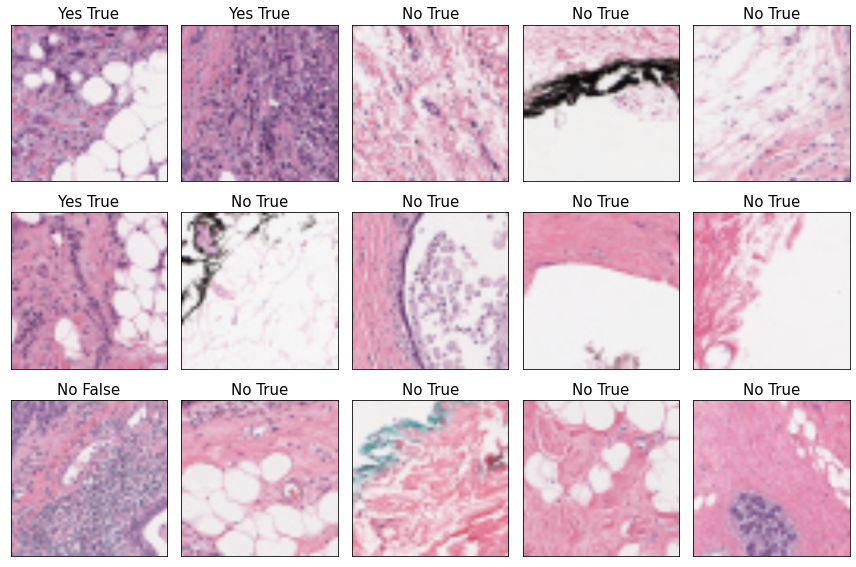

In [ ]:
for x in train_ds.take(1):

    plt.figure(figsize=(12,8))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(x[0][i])

        p = (loaded_model.predict(x[0][i].numpy().reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)) > 0.5).astype(int)[0, 0]

        if x[1][i] == 0:
            plt.title(f"No {p == 0}", size = 15, color = "black")
        if x[1][i] == 1:
            plt.title(f"Yes {p == 1}", size = 15, color = "black")

        plt.xticks([])
        plt.yticks([])

In [ ]:
print("Classification Report")
print(classification_report(Y_actual, Y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Benign       0.84      0.92      0.88     45303
   Malignant       0.78      0.61      0.69     19800

    accuracy                           0.83     65103
   macro avg       0.81      0.77      0.78     65103
weighted avg       0.83      0.83      0.82     65103



In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_actual, y_pred)
auc_val = auc(fpr, tpr)

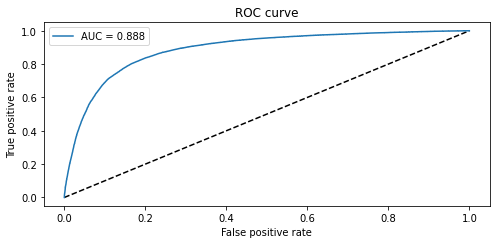

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()